In [2]:
import gzip
import re
import numpy as np
import pandas as pd
from pycombat import Combat
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
def parse_multi_sample_series_matrix(path, study_id):
    """
    Parse GEO series_matrix with multi-sample columns.
    Returns: DataFrame indexed by GSM (sample_id)
    with columns: study, raw_text, condition
    """
    col_data = {}

    with gzip.open(path, "rt") as f:
        for line in f:
            if not line.startswith("!Sample_"):
                continue
            parts = line.strip().split("\t")
            field = parts[0].replace("!Sample_", "")
            values = [v.strip('"') for v in parts[1:]]
            col_data[field] = values

    df = pd.DataFrame(col_data)
    df = df.rename(columns={"geo_accession": "sample_id"})
    df["study"] = study_id

    # combine all non-core text for condition heuristic
    text_fields = [c for c in df.columns if c not in ["sample_id", "study"]]
    df["raw_text"] = df[text_fields].astype(str).agg(" ; ".join, axis=1).str.lower()

    cond = []
    for txt in df["raw_text"]:
        if ("normal" in txt or "control" in txt) and "ssc" not in txt:
            cond.append("Control")
        elif "ssc" in txt and ("lung" in txt or "fibrosis" in txt or "ild" in txt):
            cond.append("SSc-ILD")
        else:
            cond.append("Other")
    df["condition"] = cond

    df = df.set_index("sample_id")
    return df


series_paths = {
    "GSE48149": "data/GSE48149_series_matrix.txt.gz",
    "GSE76808": "data/GSE76808_series_matrix.txt.gz",
}

meta_list = []
for study, path in series_paths.items():
    print("Parsing", study)
    meta = parse_multi_sample_series_matrix(path, study)
    print(f"  Parsed {meta.shape[0]} samples")
    meta_list.append(meta)

meta_geo = pd.concat(meta_list, axis=0)
meta_geo = meta_geo[meta_geo["condition"].isin(["SSc-ILD", "Control"])]

Parsing GSE48149
  Parsed 53 samples
Parsing GSE76808
  Parsed 18 samples


In [4]:
def load_gpl(gpl_path):
    print("Parsing GPL annotation:", gpl_path)

    rows = []
    inside = False
    with gzip.open(gpl_path, "rt", errors="ignore") as f:
        for line in f:
            if line.startswith("!platform_table_begin"):
                inside = True
                continue
            if line.startswith("!platform_table_end"):
                inside = False
                continue
            if inside:
                rows.append(line.rstrip("\n"))

    df = pd.DataFrame(
        [r.split("\t") for r in rows[1:]],
        columns=rows[0].split("\t")
    )

    df.columns = df.columns.str.lower()

    probe_col = None
    for c in ["id", "id_ref", "probe_id"]:
        if c in df.columns:
            probe_col = c
            break
    if probe_col is None:
        raise ValueError("No probe column in GPL")

    gene_col = None
    for c in df.columns:
        if "symbol" in c or c == "gene":
            gene_col = c
            break
    if gene_col is None:
        raise ValueError("No gene symbol column in GPL")

    df = df[[probe_col, gene_col]].copy()
    df.columns = ["probe", "gene"]
    df["gene"] = df["gene"].str.upper().str.replace("///.*", "", regex=True)

    mapping = df.set_index("probe")["gene"].to_dict()
    print(f" → Loaded {len(mapping)} probe→gene mappings")
    return mapping

In [5]:
def load_series_matrix(path, gpl_map):
    print("Loading expression:", path)

    # find header row
    with gzip.open(path, "rt") as f:
        for line in f:
            if line.startswith("!series_matrix_table_begin"):
                break
        header = next(f).strip().split("\t")

    # read entire table
    df = pd.read_csv(path, sep="\t", comment="!", header=None, low_memory=False)
    df.columns = header

    df = df.rename(columns={df.columns[0]: "probe"})
    df = df.set_index("probe")

    # convert all expression columns to numeric; force errors -> NaN
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # drop columns with all NaN (rare)
    df = df.dropna(axis=1, how='all')

    # map probe → gene
    df["gene"] = df.index.map(gpl_map).fillna("")
    df = df[df["gene"] != ""]

    # group by gene, compute mean across probes
    gene_df = df.groupby("gene").mean(numeric_only=True)

    print(" → Gene matrix:", gene_df.shape)
    return gene_df

In [6]:
gpl_maps = {
    "GSE48149": load_gpl("data/GPL16221.annot.gz"),
    "GSE76808": load_gpl("data/GPL571.annot.gz"),
}

expr_geo = {
    "GSE48149": load_series_matrix("data/GSE48149_series_matrix.txt.gz", gpl_maps["GSE48149"]),
    "GSE76808": load_series_matrix("data/GSE76808_series_matrix.txt.gz", gpl_maps["GSE76808"]),
}


Parsing GPL annotation: data/GPL16221.annot.gz
 → Loaded 22304 probe→gene mappings
Parsing GPL annotation: data/GPL571.annot.gz
 → Loaded 22277 probe→gene mappings
Loading expression: data/GSE48149_series_matrix.txt.gz
 → Gene matrix: (18630, 53)
Loading expression: data/GSE76808_series_matrix.txt.gz
 → Gene matrix: (13434, 18)


In [7]:
df81292 = pd.read_excel("data/GSE81292_GEO_analysis_mRNA.xlsx", header=1)

sample_cols_81292 = [c for c in df81292.columns if c.startswith("HC") or c.startswith("SD")]

expr81292 = df81292[["Symbol"] + sample_cols_81292].copy()
expr81292 = expr81292.dropna(subset=["Symbol"])
expr81292 = expr81292.groupby("Symbol").mean()   # collapse duplicate symbols

print("GSE81292 expression matrix:", expr81292.shape)

meta_81292 = pd.DataFrame(index=sample_cols_81292)
meta_81292["study"] = "GSE81292"
meta_81292["condition"] = np.where(meta_81292.index.str.startswith("HC"),
                                   "Control", "SSc-ILD")
meta_81292["raw_text"] = "from XLSX; lung SSc vs HC"


GSE81292 expression matrix: (11999, 20)


/share/pkg.8/python3/3.12.4/install/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [8]:
# All three expression matrices: gene × sample
expr_48149 = expr_geo["GSE48149"]
expr_76808 = expr_geo["GSE76808"]

# Common genes across all 3 datasets
common_genes = set(expr_48149.index) & set(expr_76808.index) & set(expr81292.index)
common_genes = sorted(list(common_genes))
print("Common genes across all 3:", len(common_genes))

expr_48149_c = expr_48149.loc[common_genes]
expr_76808_c = expr_76808.loc[common_genes]
expr_81292_c = expr81292.loc[common_genes]

# Merge along samples
expr_merged = pd.concat(
    [expr_48149_c, expr_76808_c, expr_81292_c],
    axis=1
)

print("Merged expression matrix:", expr_merged.shape)

# Remove all quotes and whitespace from column names
expr_merged.columns = (
    expr_merged.columns
    .str.replace('"', '', regex=False)
    .str.replace("'", "", regex=False)
    .str.strip()
)

meta_geo.index = (
    meta_geo.index
    .str.replace('"', '', regex=False)
    .str.replace("'", "", regex=False)
    .str.strip()
)

meta_81292.index = (
    meta_81292.index
    .str.replace('"', '', regex=False)
    .str.replace("'", "", regex=False)
    .str.strip()
)

meta_geo_sub = meta_geo.loc[expr_merged.columns.intersection(meta_geo.index)]

meta_all = pd.concat([meta_geo_sub, meta_81292], axis=0)

# Critical: reorder to match expression matrix
meta_all = meta_all.loc[expr_merged.columns]

print("Meta shape:", meta_all.shape)

Common genes across all 3: 9520
Merged expression matrix: (9520, 91)
Meta shape: (91, 35)


In [9]:
# --- Step 1: prepare expression (samples × genes) ---
combat_input_df = expr_merged.T

# Convert to numpy
combat_input = combat_input_df.values

# --- Step 2: prepare batch ---
batch = meta_all["study"].values   # vector of length N samples

# Encode batch as integers
batch_unique = {b:i for i,b in enumerate(np.unique(batch))}
batch_numeric = np.array([batch_unique[b] for b in batch])

# --- Step 3: prepare covariates ---
# One-hot encode condition
covars_df = pd.get_dummies(meta_all["condition"], drop_first=True)

# Make covariates a numpy matrix (samples × covariates)
covars = covars_df.values

# --- Step 4: run ComBat using numpy arrays ---
combat = Combat()

combat_corrected = combat.fit_transform(
    combat_input,      # numpy matrix (samples × genes)
    batch_numeric,     # numeric vector
    covars             # numeric matrix
)

# --- Step 5: convert back to DataFrame ---
expr_corrected = pd.DataFrame(
    combat_corrected.T,
    index=expr_merged.index,
    columns=expr_merged.columns
)

print("Combat corrected shape:", expr_corrected.shape)

# Use ONLY Combat-corrected raw values for DE
expr_for_de = expr_corrected.copy()

# Confirm dimensions
print("Expression for DE:", expr_for_de.shape)

# Ensure all values are numeric float
expr_for_de = expr_for_de.astype(float)

Combat corrected shape: (9520, 91)
Expression for DE: (9520, 91)


In [10]:
expr = expr_81292_c        # gene × samples
meta = meta_81292.copy()   # only GSE81292 metadata

# Build design matrix
meta["condition_bin"] = (meta["condition"] == "SSc-ILD").astype(int)
X = sm.add_constant(meta["condition_bin"]).astype(float)

genes = expr.index
samples = expr.columns

logFC_list = []
pval_list = []

for gene in genes:
    y = expr.loc[gene, samples].astype(float).values
    model = sm.OLS(y, X).fit()
    logFC_list.append(model.params["condition_bin"])
    pval_list.append(model.pvalues["condition_bin"])

de = pd.DataFrame({"logFC": logFC_list, "pval": pval_list}, index=genes)
de["FDR"] = multipletests(de["pval"], method="fdr_bh")[1]
de = de.sort_values("FDR")

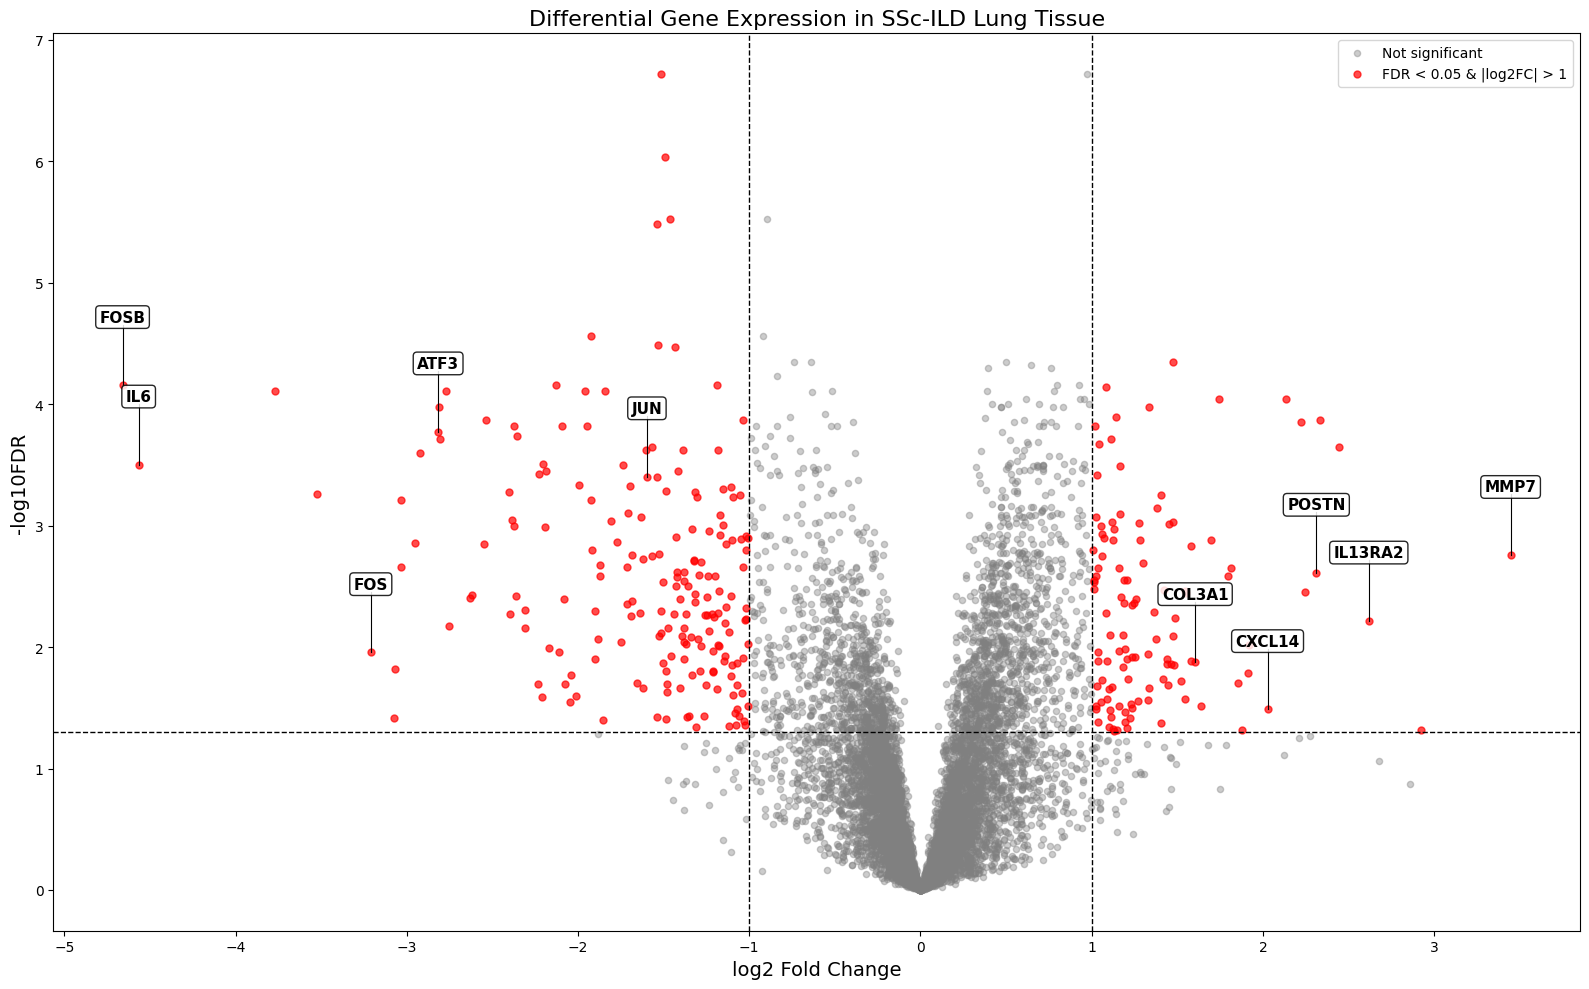

In [53]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs("results", exist_ok=True)

# -----------------------------
# Prepare DE table
# -----------------------------
df = de.copy()
df["neglog10FDR"] = -np.log10(df["FDR"])

# Significance mask: FDR + effect size
sig_mask = (df["FDR"] < 0.05) & (df["logFC"].abs() > 1)

# -----------------------------
# Genes to label (curated)
# -----------------------------
genes_to_label = [
    # Fibrosis / ECM / remodeling
    "MMP7", "POSTN", "COL3A1", "CXCL14", "IL13RA2",
    # Inflammatory / immediate-early
    "IL6", "FOS", "FOSB", "JUN", "ATF3"
]

label_df = df.loc[df.index.isin(genes_to_label)].copy()

# -----------------------------
# Volcano plot
# -----------------------------
plt.figure(figsize=(16, 10))

# Non-significant points
plt.scatter(
    df.loc[~sig_mask, "logFC"],
    df.loc[~sig_mask, "neglog10FDR"],
    color="gray", alpha=0.4, s=20,
    label="Not significant"
)

# Significant points
plt.scatter(
    df.loc[sig_mask, "logFC"],
    df.loc[sig_mask, "neglog10FDR"],
    color="red", alpha=0.7, s=25,
    label="FDR < 0.05 & |log2FC| > 1"
)

# Threshold lines
plt.axvline(1, color="black", linestyle="--", linewidth=1)
plt.axvline(-1, color="black", linestyle="--", linewidth=1)
plt.axhline(-np.log10(0.05), color="black", linestyle="--", linewidth=1)

# -----------------------------
# Label selected genes
# -----------------------------
for gene, row in label_df.iterrows():
    x = row["logFC"]
    y = row["neglog10FDR"]

    label_y = y + 0.5

    # Leader line
    plt.plot([x, x], [y, label_y], color="black", linewidth=0.8)

    # Gene label
    plt.text(
        x, label_y, gene,
        fontsize=11, weight="bold",
        ha="center", va="bottom",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.85)
    )

# -----------------------------
# Formatting
# -----------------------------
plt.xlabel("log2 Fold Change", fontsize=14)
plt.ylabel("-log10FDR", fontsize=14)
plt.title("Differential Gene Expression in SSc-ILD Lung Tissue", fontsize=16)
plt.legend()
plt.tight_layout()

# Save figure
plt.savefig("results/Volcano.png", dpi=300, bbox_inches="tight")
plt.show()


In [12]:
# ============================================================
# GO INPUT: significant genes
# Criteria: FDR < 0.05 AND |log2FC| > 1
# ============================================================

go_df = df[
    (df["FDR"] < 0.05) &
    (df["logFC"].abs() > 1)
].copy()

go_genes = (
    go_df
    .index
    .astype(str)
    .unique()
    .tolist()
)

print(f"GO input genes (FDR < 0.05 & |log2FC| > 1): {len(go_genes)}")

# Save for reproducibility
pd.Series(go_genes).to_csv(
    "results/GO_input_genes_all.txt",
    index=False,
    header=False
)


GO input genes (FDR < 0.05 & |log2FC| > 1): 310


In [15]:
# ================================
# GO enrichment on significant genes
# ================================

import gseapy as gp
import pandas as pd
import os

# ----------------
# Input
# ----------------
gene_file = "results/GO_input_genes_all.txt"
outdir = "results/GO_results"

os.makedirs(outdir, exist_ok=True)

# Load gene list
genes = (
    pd.read_csv(gene_file, header=None)
    .iloc[:, 0]
    .dropna()
    .astype(str)
    .tolist()
)

print(f"Loaded {len(genes)} genes for GO enrichment")

# ----------------
# Run GO (Biological Process)
# ----------------
enr = gp.enrichr(
    gene_list=genes,
    gene_sets="GO_Biological_Process_2021",
    organism="Human",      # GEO lung data = human
    outdir=outdir,
    cutoff=0.05
)


Loaded 310 genes for GO enrichment


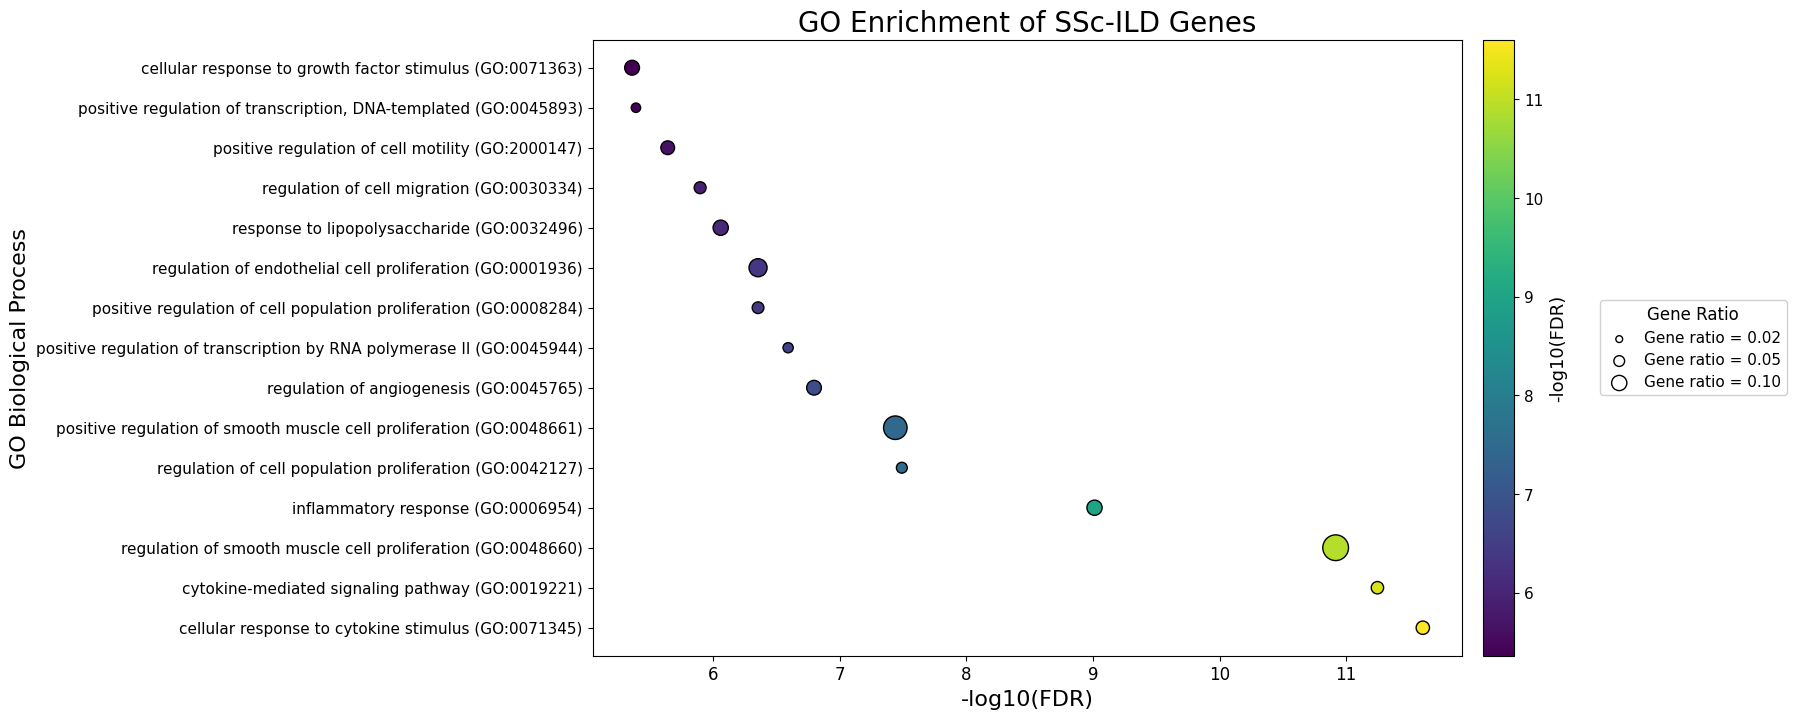

In [42]:
# ================================
# Custom GO dot plot (polished, larger labels)
# ================================

import matplotlib.pyplot as plt
import numpy as np

go = enr.results.copy()
go = go[go["Adjusted P-value"] < 0.05]

TOP_N = 15
go = go.sort_values("Adjusted P-value").head(TOP_N)

go["GeneRatio"] = go["Overlap"].str.split("/").apply(
    lambda x: int(x[0]) / int(x[1])
)

fig, ax = plt.subplots(figsize=(16, 8))

scatter = ax.scatter(
    x=-np.log10(go["Adjusted P-value"]),
    y=go["Term"],
    s=go["GeneRatio"] * 1200,
    c=-np.log10(go["Adjusted P-value"]),
    cmap="viridis",
    edgecolor="black"
)

# ----------------
# Size legend (Gene Ratio)
# ----------------
size_values = [0.02, 0.05, 0.10]
size_handles = [
    ax.scatter([], [], s=v * 1200, edgecolors="black", facecolors="none")
    for v in size_values
]

legend = ax.legend(
    size_handles,
    [f"Gene ratio = {v:.2f}" for v in size_values],
    title="Gene Ratio",
    loc="center left",
    bbox_to_anchor=(1.15, 0.5),
    frameon=True
)

legend.get_title().set_fontsize(12)
for text in legend.get_texts():
    text.set_fontsize(11)

legend.get_frame().set_alpha(0.9)

# Labels
ax.set_xlabel("-log10(FDR)", fontsize=16)
ax.set_ylabel("GO Biological Process", fontsize=16)
ax.set_title("GO Enrichment of SSc-ILD Genes", fontsize=20)

# Increase tick label sizes
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=11)

# Colorbar
cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label("-log10(FDR)", fontsize=13)
cbar.ax.tick_params(labelsize=11)

# Reserve space on the right for legend
plt.subplots_adjust(right=0.78)

plt.savefig("results/GO_BP_dotplot.png", dpi=300, bbox_inches="tight")
plt.show()


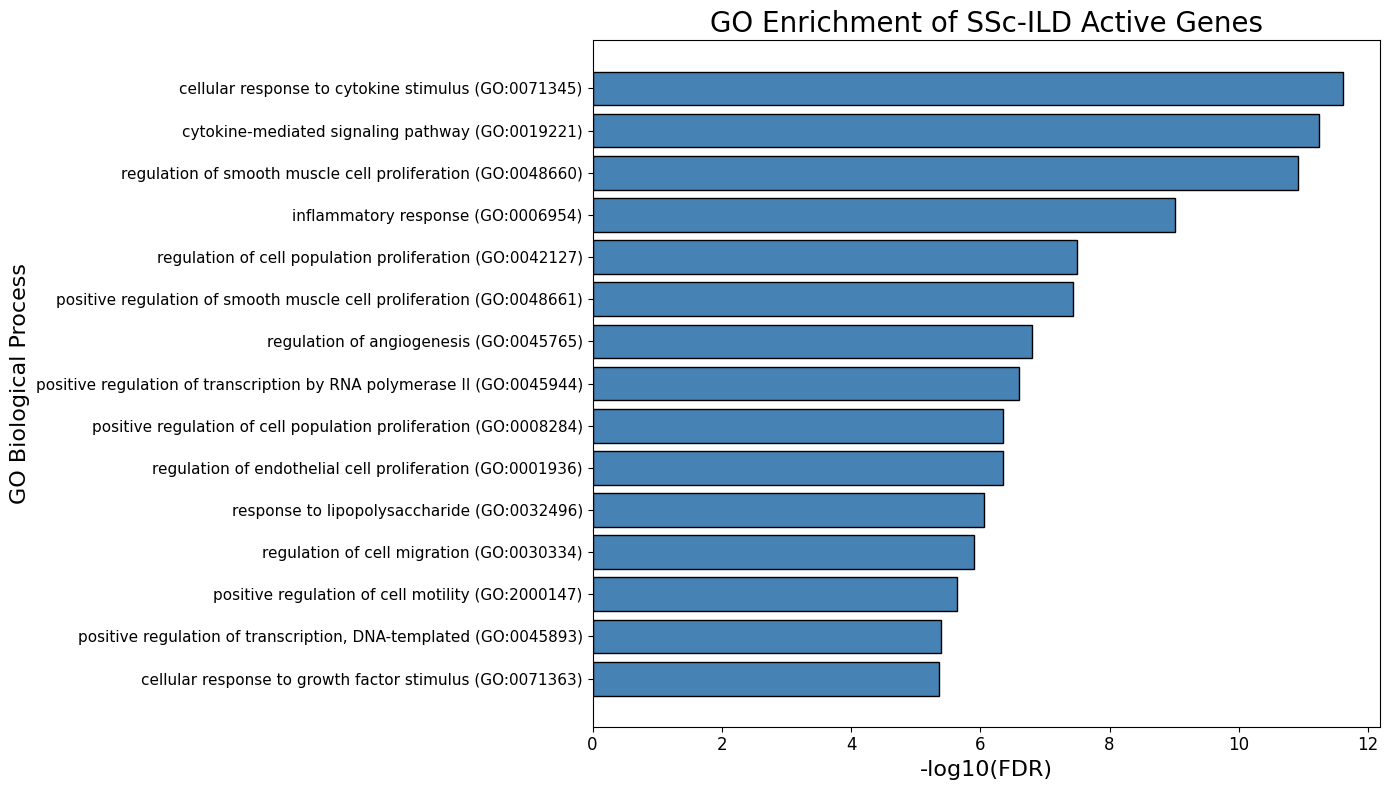

In [47]:
# ================================
# GO enrichment bar plot
# ================================

import matplotlib.pyplot as plt
import numpy as np

# Copy results
go = enr.results.copy()

# Keep significant terms only
go = go[go["Adjusted P-value"] < 0.05]

# Select top N terms
TOP_N = 15
go = go.sort_values("Adjusted P-value").head(TOP_N)

# Compute -log10(FDR)
go["neglog10FDR"] = -np.log10(go["Adjusted P-value"])

# Reverse order so most significant is on top
go = go.iloc[::-1]

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

ax.barh(
    go["Term"],
    go["neglog10FDR"],
    color="steelblue",
    edgecolor="black"
)

ax.set_xlabel("-log10(FDR)", fontsize=16)
ax.set_ylabel("GO Biological Process", fontsize=16)
ax.set_title("GO Enrichment of SSc-ILD Active Genes", fontsize=20)

# Increase label sizes
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=11)

plt.tight_layout()
plt.savefig("results/GO_BP_barplot.png", dpi=300, bbox_inches="tight")
plt.show()
